# Astronomical Image Reduction

    Created: Zachary Lane, June 2024
    Last Edited: C.Worley, July 2025

This tutorial introduces students to astronomical image reduction.

Work your way through the tutorial, **reading each code cell carefully before running it**. This is a live document, all the cells can easily be edited, and re-run any time you wish. Ask questions if you need to.


In [1]:
import os # A module for communicating with the operating system e.g. commands and files
import glob # A module for searching data files
from os import killpg

import matplotlib.pyplot as plt # A plotting library
import numpy as np # Numerical Python, great for vectorised equations
import scipy # Scientific Python, great for algorithms and optimisation
import pandas as pd # DataFrames for organising data/tables
from astropy.io import fits # Astronomy Python for opening ".fits" files
from photutils.background import Background2D, MedianBackground # Fitting background surfaces to astronomical images
from copy import deepcopy # A module for copying objects
import warnings # To ignore our problems

warnings.filterwarnings('ignore', category=RuntimeWarning) #Ignores some warnings

#%matplotlib widget


### Image Reduction formula

We will be reducing our images based on the following formula...

$$I_s^{} = \frac{I_r^{} - {\rm master}[D_I^{}]}{{\rm master}[{\rm cal.}(F_I^{} - D_F^{})]} - B$$

Where:

$I_s$ - science image

$I_r$ - raw image

$D_I$ - Darks with the same exposure time as the raw image

$F_I$ - Flats with the same filter as the raw image

$D_F$ - Darks with the same exposure time as the flat image

$B$ - Background signal


## File Overview

 Use the file organising section from the first tutorial to organise the files into three types: Raw Science (or Lights), Flats, or Darks.

 The files can be found on the MacDiarmid server, under the folder: ??/ASTR211/2025_Lab_Files/Photometry/Reduction_Lab/Basic_Reduction_1/

(A slightly more difficult set of files is under Basic_Reduction_2)

Consider these points:
* Looking through the files in the folder, can you tell anything about the files from the filename?
* Review the FITS notebook from Lab 1. Use python to open one of the files and examine the FITS header (primary or another extension?). Can you extract the information you need from the header?
* Review the Python notebook from Lab 1, in particular the File Organisation section. Use Python to print to screen the filename and the keywords from the primary header for image type ('IMAGETYP') and exposure time ('EXPTIME') for each file.

## Warning!
In jupyter notebooks, when reading in a fits file to get the 'data' and 'header' from an extension, these are kept live. If you do actions on the 'data' and 'header', jupyter notebook (without notice) updates the original file on the disk. So your original data gets changed without your knowledge!

Avoid this by using .copy() whenever accessing 'data' or 'header', particularly if you are doing actions on these. e.g.:

`hdul = fits.open(file)`

`hdr = hdul[0].header.copy()`

`data = hdul[0].data.copy()`


In [5]:
# The following code is the simplest way to do this with the methods that the students know in terms of lists and loops

# Basic 1
folder = 'Basic_Reduction_1/'  # Filenames are descriptive, exact files, minimum exposures times
#folder = '/Volumes/ASTR211/2025_Lab_Files/Photometry/Reduction_Lab/Basic_Reduction_1/'  # Filenames are descriptive, exact files, minimum exposures times
# Basic 2 - more file curation required and a variety of exposure times for flats and darks
# folder = '/Volumes/ASTR211/2025_Lab_Files/Photometry/Reduction_Lab/Basic_Reduction_2/' # Running numbers for filenames, more variety in exposure times for flats and darks
files = glob.glob(folder + '*.fit*')

darks = []
flats = []
science = []

for file in files:
    hdul = fits.open(file)
    hdr = hdul[0].header

    if "IMAGETYP" in hdr:
        if "dark" in hdr['IMAGETYP'].lower():
            darks.append(file)
        elif "flat" in hdr['IMAGETYP'].lower():
            flats.append(file)
        elif "light" in hdr['IMAGETYP'].lower():
            science.append(file)
    else:
        raise ValueError("IMAGETYP not found in header")

    print(file, hdr['IMAGETYP'], hdr['EXPTIME'])

Basic_Reduction_1/Dark-0005_15.fit Dark Frame 15.0
Basic_Reduction_1/Darks-0002_60.fit Dark Frame 60.0
Basic_Reduction_1/TYC8555-338-1-0010_r.fit Light Frame 60.0
Basic_Reduction_1/TYC8555-338-1-0009_r.fit Light Frame 60.0
Basic_Reduction_1/Flat-0007_r.fit Flat Field 15.0
Basic_Reduction_1/Dark-0007_15.fit Dark Frame 15.0
Basic_Reduction_1/TYC8555-338-1-0008_r.fit Light Frame 60.0
Basic_Reduction_1/Flat-0008_r.fit Flat Field 15.0
Basic_Reduction_1/Flat-0011_r.fit Flat Field 15.0
Basic_Reduction_1/TYC8555-338-1-0002_r.fit Light Frame 60.0
Basic_Reduction_1/Darks-0003_60.fit Dark Frame 60.0
Basic_Reduction_1/Darks-0001_60.fit Dark Frame 60.0
Basic_Reduction_1/Dark-0006_15.fit Dark Frame 15.0
Basic_Reduction_1/TYC8555-338-1-0006_r.fit Light Frame 60.0
Basic_Reduction_1/TYC8555-338-1-0004_r.fit Light Frame 60.0
Basic_Reduction_1/Flat-0012_r.fit Flat Field 15.0
Basic_Reduction_1/TYC8555-338-1-0003_r.fit Light Frame 60.0
Basic_Reduction_1/Flat-0009_r.fit Flat Field 15.0
Basic_Reduction_1/TYC

## Curating your Image Files

Our goal is to calibrate the science observations taken in the "r" filter that have an exposure time of 60s.

Images that all have the same readout time all have the same amount of instrumentation noise. For our set, the images are taken within a few days of each other. However, this is not always the case.

To calibrate (reduce) our science images we need the appropriate set of calibration files.
1. "Lights" with exposure time of 60s and using the "r" filter
2. "Flats" using the "r" filter
3. "Darks" to use with the "Lights" so exposure time of 60s
4. "Darks" to use the the "Flats" so exposure time matching the exposure time of the "Flats"

Follow these steps:
1. Collate your files such that you have the required sets as above. (Example given for the science/lights).
2. What are the exposure time(s) of your "Flats"? Do you have a useful set?
3. Do you have "Darks" that can be used with your "Flats"?
4. Write a summary of your sets of files including: Image Type, Filter used, Exposure Time, Number of files.

Plot an example of each type of image using imshow (see examples of imshow in Lab 1 Part 1).

Discuss what you have collected with a tutor/lecturer.


Basic_Reduction_1/Dark-0005_15.fit
Basic_Reduction_1/Darks-0002_60.fit
Basic_Reduction_1/Dark-0007_15.fit
Basic_Reduction_1/Darks-0003_60.fit
Basic_Reduction_1/Darks-0001_60.fit
Basic_Reduction_1/Dark-0006_15.fit


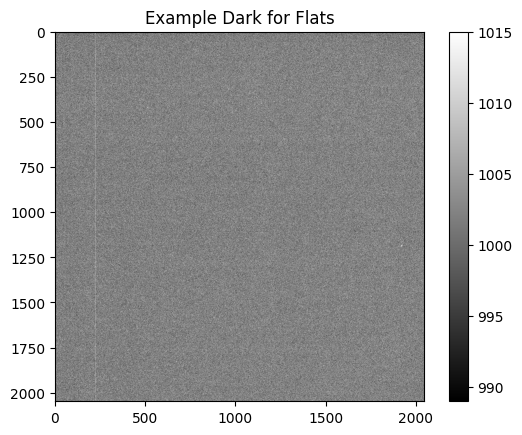

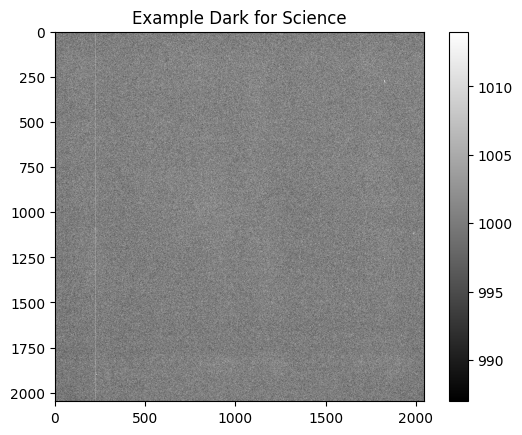

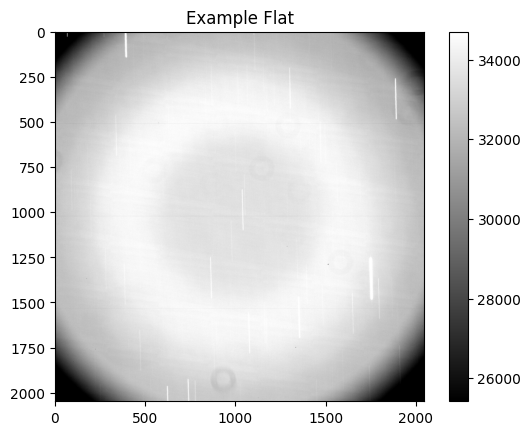

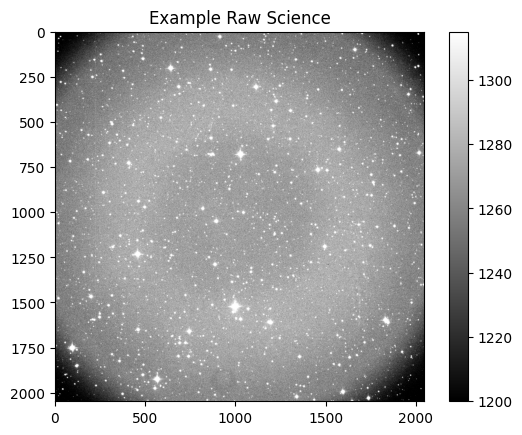

In [42]:
# Possible process to do the above.
# Students will do it in a variety of ways

listfiles_darks4science = []
listfiles_darks4flats = []
listfiles_flats = []
listfiles_science = []

darks4science_data = []
darks4flats_data = []
flats_data = []
science_data = []

for file in darks:
    hdul = fits.open(file)
    hdr = hdul[0].header
    print(file)
    if hdr['EXPTIME'] == 60:
        listfiles_darks4science.append(file)
        darks4science_data.append(hdul[0].data.copy())
    elif hdr['EXPTIME'] == 15:
        listfiles_darks4flats.append(file)
        darks4flats_data.append(hdul[0].data.copy())
    hdul.close()

for file in flats:
    hdul = fits.open(file)
    hdr = hdul[0].header
    if hdr['FILTER'] == 'r':
        listfiles_flats.append(file)
        flats_data.append(hdul[0].data.copy())
    hdul.close()

for file in science:
    hdul = fits.open(file)
    hdr = hdul[0].header
    if hdr['FILTER'] == 'r':
        if hdr['EXPTIME'] == 60:
            listfiles_science.append(file)
            science_data.append(hdul[0].data.copy())
    hdul.close()

plt.figure()
plt.imshow(darks4flats_data[0], cmap = 'gray', vmin = np.nanpercentile(darks4flats_data[0], 2), vmax = np.nanpercentile(darks4flats_data[0], 98)) # 2d plotting
#plt.axis('off') # turning off axis labels
plt.title('Example Dark for Flats')
plt.colorbar()
plt.savefig('Saved_Figures/Example_Dark4Flats.png')
plt.show()

plt.figure()
plt.imshow(darks4science_data[0], cmap = 'gray', vmin = np.nanpercentile(darks4science_data[0], 2), vmax = np.nanpercentile(darks4science_data[0], 98)) # 2d plotting
#plt.axis('off') # turning off axis labels
plt.title('Example Dark for Science')
plt.colorbar()
plt.savefig('Saved_Figures/Example_Dark4Science.png')
plt.show()

plt.figure()
plt.imshow(flats_data[0], cmap = 'gray', vmin = np.nanpercentile(flats_data[0], 2), vmax = np.nanpercentile(flats_data[0], 98)) # 2d plotting
#plt.axis('off') # turning off axis labels
plt.title('Example Flat')
plt.colorbar()
plt.savefig('Saved_Figures/Example_Flat.png')
plt.show()

plt.figure()
plt.imshow(science_data[0], cmap = 'gray', vmin = np.nanpercentile(science_data[0], 2), vmax = np.nanpercentile(science_data[0], 98)) # 2d plotting
#plt.axis('off') # turning off axis labels
plt.title('Example Raw Science')
plt.colorbar()
plt.savefig('Saved_Figures/Example_RawScience.png')
plt.show()


For Tutors - the sets should be:

- Lights -- 60s -- r Filter -- 10 images
- Darks -- 60s -- No Filter -- 3 images
- Flats -- 15s -- r Filter -- 6 images
- Darks -- 15s -- No Filter -- 3 images


## Data Reduction: Step 1 - Generating the Master Darks

Now the files are organised we will start the data reduction.

The first step is to generate the Master Darks:
$${\rm master}[D_X^{}]$$

We require two Master Darks: a Master Dark for the Flats, and a Master Dark for the Science images.


The following cell provides a simple method to generate a master dark.

### 1.1 - Master Dark for the Flats
Modify the method to read in your list of darks associated with your flats i.e. replace the dark file list variable with the variable name you have used above for your list of darks associated with your flats.

Plot this using imshow.

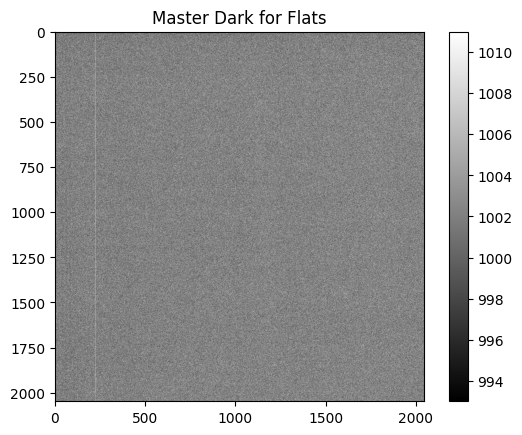

In [43]:
# Variable in which to store the data for each dark in the list
darks4flats_data = []

# Iterate over list of dark files, open each file, extract data, append to darks_data
for dark_file in listfiles_darks4flats:
    hdul = fits.open(dark_file)
    darks4flats_data.append(hdul[0].data.copy()) # Append the data to the list
    hdul.close()

# Take median of the darks data to create the master dark for the flats
master_dark4flats = np.median(darks4flats_data, axis=0) # Median combine the darks

plt.figure()
plt.imshow(master_dark4flats, cmap = 'gray', vmin = np.nanpercentile(master_dark4flats, 2), vmax = np.nanpercentile(master_dark4flats, 98)) # 2d plotting
#plt.axis('off') # turning off axis labels
plt.title('Master Dark for Flats')
plt.colorbar()
plt.show()

Consider why is a median is used to combine the darks? Why not use a mean? Test this and discuss with tutor/lecturer.

### 1.2 - Master Dark for the Science Images

Copy your code above into another cell below.

Modify your code to now read in your list of darks associated with your science images.

Plot this using imshow.

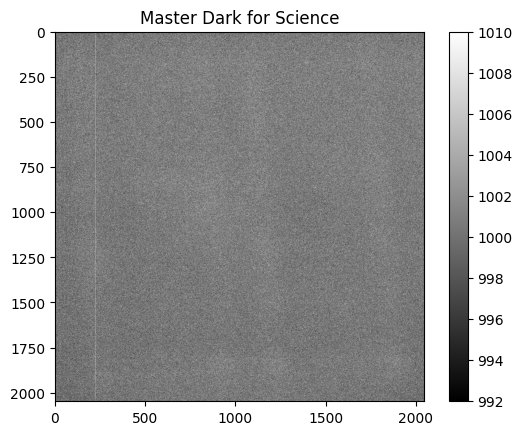

In [44]:
# Variable in which to store the data for each dark in the list
darks4science_data = []

# Iterate over list of dark files, open each file, extract data, append to darks_data
for dark_file in listfiles_darks4science:
    hdul = fits.open(dark_file)
    darks4science_data.append(hdul[0].data.copy()) # Append the data to the list
    hdul.close()

# Take median of the darks data to create the master dark for the flats
master_dark4science = np.nanmedian(darks4science_data, axis=0) # Median combine the darks

plt.figure()
plt.imshow(master_dark4science, cmap = 'gray', vmin = np.nanpercentile(master_dark4science, 2), vmax = np.nanpercentile(master_dark4science, 98)) # 2d plotting
#plt.axis('off') # turning off axis labels
plt.colorbar()
plt.title('Master Dark for Science')
plt.show()


How does the Master Dark for Flats compare to the Master Dark for Science? Discuss with a tutor/lecturer.

### Data Reduction Step 2 - Generating the Master Flat

Generating the Master Flat is more complicated than generating the Master Darks. You can start with a for-loop similar to that used for the darks.

These are the steps:
1. Subtract the Master Dark for Flats from each Flat image (generate Dark-subtracted-Flats)
2. Check the median count of each Dark-subtracted-Flat. Ideally it should be between 24000 and 45000 counts. (This maximises the signal but is not within the non-linear regime - what is that?).
3. Reject the Dark-subtracted-Flats that do not meet this criteria.
4. For each remaining Dark-subtracted-Flats:
    4.1 Calculate the median count of the Dark-subtracted-Flat,
    4.2 Divided the Dark-subtracted-Flat by its median count (this normalises the Dark-subtracted-Flat).
5. Median-combine the normalised Dark-subtracted-Flats to create the Master Flat.

Plot this with imshow.

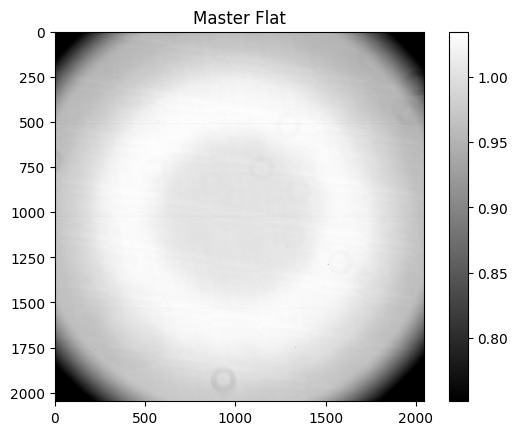

In [45]:
flats_data = []
flats_data_norej = []

for flat in listfiles_flats:

    #Open fits file and extract flat image
    hdul = fits.open(flat)
    flat_data = hdul[0].data.copy()
    hdul.close()

    # Ensure dataype is float
    flat_data = flat_data.astype(float)  # Ensure variable datatype is a float

    # Subtract the 'Master Dark for Flats' from the Flat
    flat_MasterDark = flat_data - master_dark4flats

    # Check that the median count is optimal: between 24000 and 45000
    # print(np.nanmedian(flat_MasterDark))
    if (np.nanmedian(flat_MasterDark) > 24000) & (np.nanmedian(flat_MasterDark) < 45000):
        #print(np.nanmedian(flat_MasterDark))
        flat_MasterDark /= np.nanmedian(flat_MasterDark)  # Normalise
        flats_data.append(flat_MasterDark)

    # Keep all flats for a comparison master flat
    flat_MasterDark /= np.nanmedian(flat_MasterDark)  # Normalise
    flats_data_norej.append(flat_MasterDark)

# Generate Master Flat as a median of the optimised, normalised, MasterDark-Subtracted-Flat
master_flat = np.nanmedian(flats_data, axis=0)

master_flat_norej = np.nanmedian(flats_data_norej, axis=0)

plt.figure()
plt.imshow(master_flat, cmap = 'gray', vmin = np.nanpercentile(master_flat, 2), vmax = np.nanpercentile(master_flat, 98)) # 2d plotting
#plt.axis('off') # turning off axis labels
plt.title('Master Flat')
plt.colorbar()
plt.show()


## Inspecting your Master Files

You now have three master calibration files:
1. Master Dark for Flats
2. Master Dark for Science
3. Master Flat

Plot each of these using imshow.

What features do you notice in each? Think about the definition of each master file. Do these look as expected?

What if you did not reject some of the individual flats due to their median count? Adjust your code to also save a version of the master flat with no rejected flats. Can you plot the flats that were rejected? Can you see why they should be rejected? What if you rejected more flats?

Discuss the images and your thought processes with a tutor/lecturer.



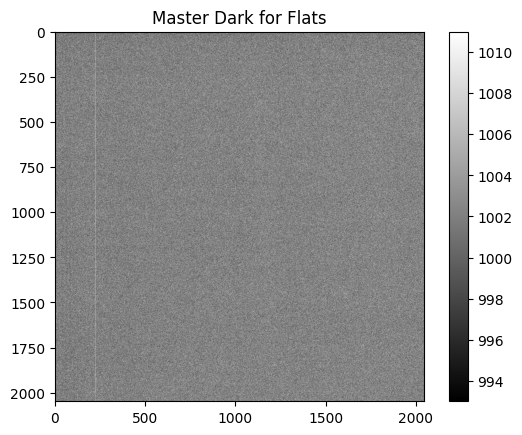

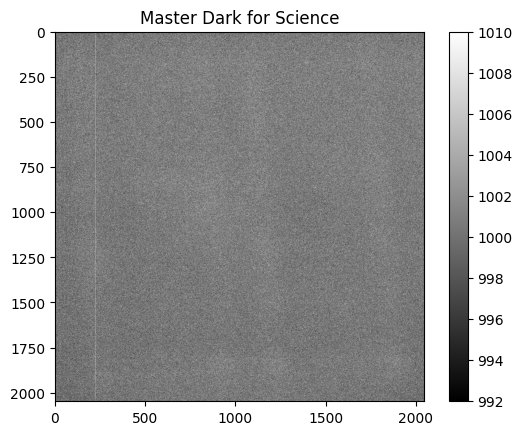

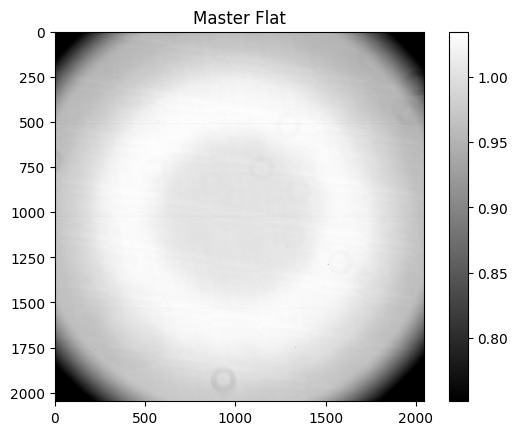

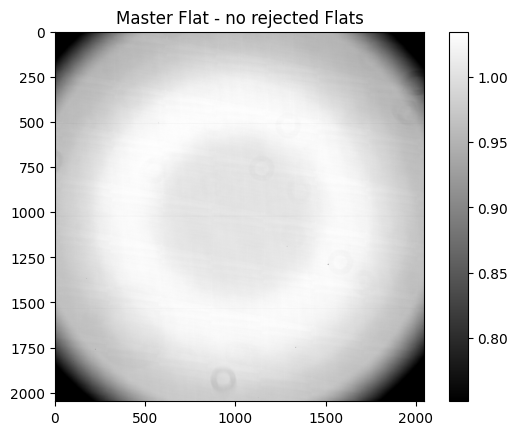

In [46]:
plt.figure()
plt.imshow(master_dark4flats, cmap = 'gray', vmin = np.nanpercentile(master_dark4flats, 2), vmax = np.nanpercentile(master_dark4flats, 98)) # 2d plotting
#plt.axis('off') # turning off axis labels
plt.title('Master Dark for Flats')
plt.colorbar()
plt.savefig('Saved_Figures/Master_Dark4Flats.png')
plt.show()

plt.figure()
plt.imshow(master_dark4science, cmap = 'gray', vmin = np.nanpercentile(master_dark4science, 2), vmax = np.nanpercentile(master_dark4science, 98)) # 2d plotting
#plt.axis('off') # turning off axis labels
plt.title('Master Dark for Science')
plt.colorbar()
plt.savefig('Saved_Figures/Master_Dark4Science.png')
plt.show()

plt.figure()
plt.imshow(master_flat, cmap = 'gray', vmin = np.nanpercentile(master_flat, 2), vmax = np.nanpercentile(master_flat, 98)) # 2d plotting
#plt.axis('off') # turning off axis labels
plt.title('Master Flat')
plt.colorbar()
plt.savefig('Saved_Figures/Master_Flat.png')
plt.show()

plt.figure()
plt.imshow(master_flat_norej, cmap = 'gray', vmin = np.nanpercentile(master_flat_norej, 2), vmax = np.nanpercentile(master_flat_norej, 98)) # 2d plotting
#plt.axis('off') # turning off axis labels
plt.title('Master Flat - no rejected Flats')
plt.colorbar()
plt.savefig('Saved_Figures/Master_Flat_NoRejections.png')
plt.show()


## Data Reduction: Step 3 - Generating Calibrated Science Images

Now use your master calibration files to reduce your "Lights" into calibrated science images.

You will use the Image Reduction formula provided above as the basis for your reduction programme.

Follow these steps for a single "Light":
1. Subtract the Master Dark for Science from the Light image to create a Dark-Subtracted_Light
2. Divide the Dark-Subtracted_Light by the Master Flat to create a Flat-Corrected-Dark-Subtracted_Light
3. Use code from Lab 2 Part 1 to estimate the background signal (B) for the Flat-Corrected-Dark-Subtracted_Light.
4. Subtract B from the Flat-Corrected-Dark-Subtracted_Light to create the Calibrated Science image.
5. Plot each image produced in steps 1. to 4 using imshow. Do you see an improvement at each step? Discuss with a tutor/lecturer.
6. Repeat steps 1. to 4. for all the Lights.
7. Plot (using imshow) an example of the raw Light image and its corresponding calibrated Light image. Did the calibration improve the image?
8. Inspect the other Light images.

Discuss your process and final images with a tutor/lecturer.


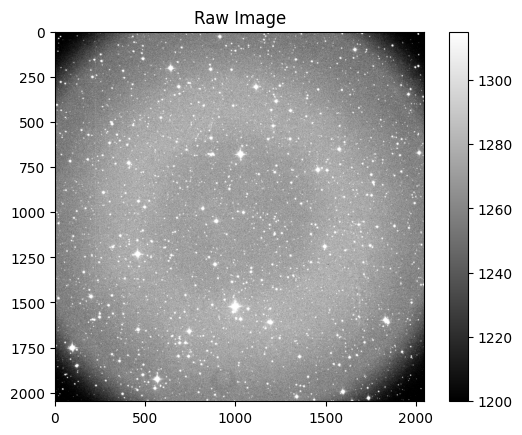

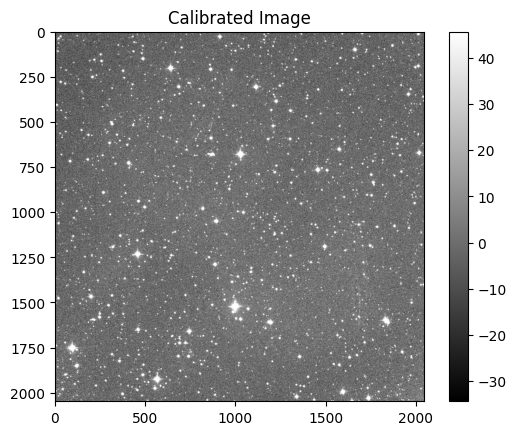

In [47]:
raw_images = []
cal_images = []
for sc in science:
    hdul = fits.open(sc)
    data = hdul[0].data.copy()
    raw_images.append(data)  # Save raw image for comparison

    data = data.astype(float)
    data -= master_dark4science
    data /= master_flat


    bkg_estimator = Background2D(data, (50, 50), filter_size=(5, 5), bkg_estimator=MedianBackground())
    median_background = bkg_estimator.background_median

    data -= median_background

    cal_images.append(data)
    hdul.close()

cal_images = np.array(cal_images)

#print(cal_images.shape)

plt.figure()
plt.imshow(raw_images[0], cmap='gray', vmin = np.nanpercentile(raw_images[0], 2), vmax = np.nanpercentile(raw_images[0], 98))
plt.colorbar()
plt.title('Raw Image')
plt.show()

plt.figure()
plt.imshow(cal_images[0], cmap='gray', vmin = np.nanpercentile(cal_images[0], 2), vmax = np.nanpercentile(cal_images[0], 98))
plt.title('Calibrated Image')
plt.colorbar()
plt.savefig('Saved_Figures/Example_CalibratedScience.png')
plt.show()


### Tutor Questions

- In this case we did not take the median of the stack of calibrated images. When do you think we would? What are the advantages of both methods?
- What parts do you think are the most challenging to automate?

## Data Reduction: Step 4 - Save your files

Save your master files and each calibrated science file as FITS files.

An example for the Master Dark for Flats is given which shows how to use an single Dark as an example of the format without over-writing the Dark.


Name them appropriately.




In [28]:
outfolder = 'Saved_Files/'

# Use example dark frame for format
filename = darks[0] # Use an individual dark to get header info
hdul = fits.open(filename, mode='update')
#data = hdul[0].data.copy() # Not used here but reminder anyway, Take a copy,
hdr = hdul[0].header.copy() # Take a copy,

# Note the format we received was data in the primary extension
# To be consistent we'll save the new files also with the data in the primary extension

# Save Master Dark for Flats
dark4flats_filename = 'MasterDark4flats.fits'
d4fhdu = fits.PrimaryHDU(data=master_dark4flats, header=hdr)
d4fhdulist = fits.HDUList([d4fhdu]) # List format (only 1 hdu in list)
d4fhdulist[0].header['COMMENT'] = 'Master Dark for Flats'
d4fhdulist.writeto(outfolder + dark4flats_filename, overwrite=True)
d4fhdulist.close()

# Use example dark frame for format
filename = darks[0]
hdul = fits.open(filename, mode='update')
#data = hdul[0].data.copy()
hdr = hdul[0].header.copy() # Take a copy,

# Master Dark for Science
dark4science_filename = 'MasterDark4science.fits'
d4shdu = fits.PrimaryHDU(data=master_dark4science, header=hdr)
d4shdulist = fits.HDUList([d4shdu]) # List format (only 1 hdu in list)
d4shdulist[0].header['COMMENT'] = 'Master Dark for Flats'
d4shdulist.writeto(outfolder + dark4science_filename, overwrite=True)
d4shdulist.close()


# Use example dark frame for format
filename = flats[0]
hdul = fits.open(filename, mode='update')
#data = hdul[0].data.copy()
hdr = hdul[0].header.copy() # Take a copy,

# Master Dark for Flat
flat_filename = 'MasterFlat.fits'
flthdu = fits.PrimaryHDU(data=master_flat, header=hdr)
flthdulist = fits.HDUList([flthdu]) # List format (only 1 hdu in list)
flthdulist[0].header['COMMENT'] = 'Master Flat'
flthdulist.writeto(outfolder + flat_filename, overwrite=True)
flthdulist.close()

# Calibrated Science images
for i in range(len(cal_images)):

    # Original data to get header info
    filename = science[i]
    print(filename)
    hdul = fits.open(filename, mode='update')
    #data = hdul[0].data.copy()
    hdr = hdul[0].header.copy() # Take a copy,

    # Out file and data
    outfilename = science[i].replace('/Volumes/ASTR211/2025_Lab_Files/Photometry/Reduction_Lab/Basic_Reduction_1/','').replace('Basic_Reduction_1/','').replace('.fit','_calibrated.fit')
    print(outfolder + outfilename)
    scihdu = fits.PrimaryHDU(data=cal_images[i], header=hdr)
    scihdulist = fits.HDUList([scihdu]) # List format (only 1 hdu in list)
    scihdulist[0].header['COMMENT'] = 'Calibrated Image'
    scihdulist.writeto(outfolder + outfilename, overwrite=True)
    scihdulist.close()

Basic_Reduction_1/TYC8555-338-1-0010_r.fit
Saved_Files/TYC8555-338-1-0010_r_calibrated.fit
Basic_Reduction_1/TYC8555-338-1-0009_r.fit
Saved_Files/TYC8555-338-1-0009_r_calibrated.fit
Basic_Reduction_1/TYC8555-338-1-0008_r.fit
Saved_Files/TYC8555-338-1-0008_r_calibrated.fit
Basic_Reduction_1/TYC8555-338-1-0002_r.fit
Saved_Files/TYC8555-338-1-0002_r_calibrated.fit
Basic_Reduction_1/TYC8555-338-1-0006_r.fit
Saved_Files/TYC8555-338-1-0006_r_calibrated.fit
Basic_Reduction_1/TYC8555-338-1-0004_r.fit
Saved_Files/TYC8555-338-1-0004_r_calibrated.fit
Basic_Reduction_1/TYC8555-338-1-0003_r.fit
Saved_Files/TYC8555-338-1-0003_r_calibrated.fit
Basic_Reduction_1/TYC8555-338-1-0001_r.fit
Saved_Files/TYC8555-338-1-0001_r_calibrated.fit
Basic_Reduction_1/TYC8555-338-1-0005_r.fit
Saved_Files/TYC8555-338-1-0005_r_calibrated.fit
Basic_Reduction_1/TYC8555-338-1-0007_r.fit
Saved_Files/TYC8555-338-1-0007_r_calibrated.fit


You've reached the end of the Lab, well done!

Make sure to discuss how you did with a tutor/lecturer.

An optional task is to plate-solve your calibrated science images. See the next cells. This can be done in your own time.


## For Tutor/Lecturer - Create pdf of exmaple images

Pdf of images so can students can see what aiming for without seeing the code

In [48]:
from PIL import Image

# List of image file paths
image_paths = ['Example_RawScience.png','Example_Dark4Flats.png', 'Example_Dark4Science.png', 'Example_Flat.png', 'Master_Dark4Flats.png', 'Master_Dark4Science.png', 'Master_Flat.png', 'Example_CalibratedScience.png']
output_pdf = 'Saved_Figures/ASTR211_Lab3_ImageReduction_SetofImages.pdf'

# Open the first image
img_list = [Image.open('Saved_Figures/'+f) for f in image_paths]

# Save the images to a PDF
img_list[0].save(output_pdf, save_all=True, append_images=img_list[1:])

## Additional Processing: Plate-Solving

Plate-solve your calibrated science images. Remind yourself what plate-solving does to the image.

### Online Option:
1. Uploading each of your calibrated science image FITS file to: https://nova.astrometry.net/upload

2. Save the plate-solved image, named appropriately.

### Python Module Option:
Work though the additional module available in Week 3 - Additional Resources section on LEARN.

-------

## Additional for Tutor benefit

This is NOT part of the lab for the students.

Below is a similar but a more basic version of the code from Zachary Lane's DINO reduction pipeline. This is designed to be an (admittedly) complex way to show the tutors, who may not be familiar with pipeline building, some of the things to consider and how they were challenged.

This code checks: 
- date tolerances
- exposure time tolerances
- readout errors
- readout mode
- filters
- exposore time
- signal from flats to calibrate the images
- ccd temperatures
- high background
- high saturation
- bad columns


In [ ]:

class Image_Analyse_Basic:
    def __init__(self, files, plot = False, flat_min = 24000, flat_max = 44000, 
                 exp_tol = 3, flat_tol = 30, dark_tol = 3, grad_threshold = 350, 
                 saturation_limit = 50000, saturation_fraction = 0.1, high_bkg = 10000, 
                 hdul_default = 0, mask_cols = False, ccd_temp_max = -18):
        
        self.files = files
        self.plot = plot

        self.flat_min = flat_min
        self.flat_max = flat_max

        self.exp_tol = exp_tol
        self.flat_tol = flat_tol
        self.dark_tol = dark_tol
        self.ccd_temp_max = ccd_temp_max

        self.grad_threshold = grad_threshold
        self.saturation_limit = saturation_limit
        self.saturation_fraction = saturation_fraction
        self.high_bkg = high_bkg

        self.hdul_default = hdul_default
        self.mask_cols = mask_cols

        self._data_organise()
        self._classify_images()
        self.process_darks()
        self.process_flats()

    def _data_organise(self):

        df = pd.DataFrame(columns=['FILENAME', 'IMAGETYP', 'EXPTIME', 'FILTER', 'READOUTM', 'DATA', 'MJD'])
        for file in self.files:
            hdul = fits.open(file)
            if len(hdul) > 1:
                print(f"Warning: {file} has more than one HDU. Using the extension {self.hdul_default}.")
                hdr = hdul[self.hdul_default].header
                data = hdul[self.hdul_default].data 
                data = data.astype(float)
            else:
                hdr = hdul[0].header
                data = hdul[0].data 
                data = data.astype(float)

            if hdr['TELESCOP'] != 'B&C':
                continue

            if hdr['CCD-TEMP'] < self.ccd_temp_max:
                saturations = (data > self.saturation_limit).flatten()
                if sum(saturations) > len(saturations) * self.saturation_fraction:
                    continue
                
                if ("IMAGETYP" in hdr):
                    imagetyp = hdr['IMAGETYP']
                    exptime = hdr['EXPTIME']
                    readoutm = hdr['READOUTM']
                    if "dark" in imagetyp.lower():
                        filter = "None"
                        bad_col, vals = self._gradient_check(data, axis = 0, threshold = 7)

                        if (bad_col == True) & self.mask_cols:
                            data[:,vals] = np.nan

                    elif "flat" in imagetyp.lower():
                        if (np.nanmedian(data) > self.flat_min) & (np.nanmedian(data) < self.flat_max):
                            flag, _ = self._gradient_check(data, threshold = self.grad_threshold)
                            filter = hdr['FILTER']
                            if flag == True:
                                continue
                        else:
                            continue
                    else:
                        filter = hdr['FILTER']
                        if (np.nanpercentile(data, 16) > self.high_bkg):
                            continue
                else:
                    raise ValueError("IMAGETYP not found in header")
                
                df.loc[len(df)] = [file, imagetyp, exptime, filter, readoutm, data, hdr['JD'] - 2400000.5]
            hdul.close()
        self.df = df

    def _gradient_check(self, data, axis = 1, threshold = 350):
        d_shape = data.shape[0]
        data_copy = deepcopy(data)

        if axis == 1:
            for idx in range(4):
                ind = int(idx*d_shape/4)
                indx = int(idx*(d_shape/4 -1))
                data_copy[indx] = np.nan
                data_copy[ind] = np.nan
            data_copy[-1] = np.nan
        elif axis == 0:
            pass
        else:
            raise ValueError("Axis must be 0 or 1")

        data_collapse = np.nanmedian(data_copy, axis = axis)
        grads = np.gradient(data_collapse)

        failed_rows = np.where(abs(grads) > threshold)[0]

        if len(failed_rows) > 0:
            return True, failed_rows
        else:
            return False, 0

    def _remove_dates(self, df1, df2, df3 = None, mode = 'EXPTIME', tol = 3, ftol = 30):
        exact_matches = df1[df1[mode].isin(df2[mode])]

        if df3 is not None:
            exact_matches_other = df1[df1[mode].isin(df3[mode])]
            exact_match_indices = exact_matches.index.union(exact_matches_other.index)
            tolerance_filter = df1[~df1.index.isin(exact_match_indices)]

            return pd.concat([exact_matches, 
                              exact_matches_other, 
                              tolerance_filter[tolerance_filter.apply(lambda row: any(abs(row[mode] - df2[mode]) <= tol) or 
                                                                      any(abs(row[mode] - df3[mode]) <= ftol), axis=1)]])

        else:
            exact_match_indices = exact_matches.index
            tolerance_filter = df1[~df1.index.isin(exact_match_indices)]

            return pd.concat([exact_matches, 
                            tolerance_filter[tolerance_filter.apply(lambda row: any(abs(row[mode] - df2[mode]) <= tol), axis=1)]])
    
    def _classify_images(self):
        df = self.df

        images_df = df.groupby(['IMAGETYP']).get_group(('Light Frame'))
        flats_df = df.groupby(['IMAGETYP']).get_group(('Flat Field'))
        darks_df = df.groupby(['IMAGETYP']).get_group(('Dark Frame'))

        images_df = self._remove_dates(images_df, darks_df, mode = 'EXPTIME', tol = self.exp_tol)
        flats_df = self._remove_dates(flats_df, darks_df, mode = 'EXPTIME', tol = self.exp_tol)
        darks_df = self._remove_dates(darks_df, flats_df, images_df, mode = 'EXPTIME', tol = self.exp_tol, ftol = self.exp_tol )

        images_df = self._remove_dates(images_df, darks_df, mode = 'MJD', tol = self.dark_tol)
        flats_df = self._remove_dates(flats_df, darks_df, mode = 'MJD', tol = self.dark_tol)
        self.darks_df = self._remove_dates(darks_df, flats_df, images_df, mode = 'MJD', tol = self.dark_tol, ftol = self.flat_tol )

        self.images_df = images_df[images_df['FILTER'].isin(flats_df['FILTER'])]
        self.flats_df = flats_df[flats_df['FILTER'].isin(images_df['FILTER'])]

        filters_df1 = set(images_df['FILTER'])
        filters_df2 = set(flats_df['FILTER'])

        only_in_df1 = filters_df1 - filters_df2
        for filter_value in only_in_df1:
            print(f"Filter: '{filter_value}' does not exist in df2")

        only_in_df2 = filters_df2 - filters_df1
        for filter_value in only_in_df2:
            print(f"Filter: '{filter_value}' does not exist in df1")

    def process_darks(self):

        self.master_dark_group = self.darks_df.groupby(['EXPTIME', 'READOUTM'])
        medians = self.master_dark_group['DATA'].apply(self._median_2d_arrays)
        self.master_darks = pd.DataFrame({'EXPTIME': medians.index.get_level_values('EXPTIME'), 'DATA': medians.values, 'READOUTM': medians.index.get_level_values('READOUTM')})
        self.master_darks.set_index('EXPTIME', inplace=True)
    
    def _median_2d_arrays(self, arrays):
        if len(arrays) == 0:
            return np.nan * np.zeros(arrays.iloc[0].shape)  # Return NaN array if empty
        return np.nanmedian(np.stack(arrays.values), axis=0)
    
    def process_flats(self):
        flatty = pd.DataFrame(columns=['FILTER', 'DATA', 'READOUTM'])
        dark_exptimes = self.master_darks.index.to_numpy()

        for idx, flat_row in self.flats_df.iterrows():
            filter_name = flat_row['FILTER']
            exptime = flat_row['EXPTIME']
            readoutm = flat_row['READOUTM']
            flat_data = flat_row['DATA']

            closest_exptime_idx = np.argmin(np.abs(dark_exptimes - exptime))
            closest_exptime = dark_exptimes[closest_exptime_idx]

            if np.abs(closest_exptime - exptime) > self.exp_tol:
                continue

            master_dark_data = self.master_darks.loc[closest_exptime, 'DATA']

            corrected_flat_data = (flat_data - master_dark_data)
            corrected_flat_data /= np.nanmedian(corrected_flat_data)

            flatty.loc[len(flatty)] = [filter_name, corrected_flat_data, readoutm]

        master_flats = (flatty.groupby(['FILTER', 'READOUTM'])['DATA'].apply(self._median_2d_arrays).reset_index())
        self.master_flats = master_flats
        self.master_flats.set_index('FILTER', inplace=True)

    def calibrated_images(self):

        master_images = pd.DataFrame(columns=['FILTER', 'EXPTIME', 'DATA', 'READOUTM'])
    
        master_images = pd.DataFrame(columns=['FILTER', 'EXPTIME', 'DATA', 'READOUTM', 'FILENAME', 'MJD'])
        dark_exptimes = self.master_darks.index.to_numpy()

        for idx, im_row in self.images_df.iterrows():
            filter_name = im_row['FILTER']
            exptime = im_row['EXPTIME']
            readoutm = im_row['READOUTM']
            im_data = im_row['DATA']
            file = im_row['FILENAME']
            mjd = im_row['MJD']

            flat_filters = self.master_flats['DATA'][filter_name]

            closest_exptime_idx = np.argmin(np.abs(dark_exptimes - exptime))
            closest_exptime = dark_exptimes[closest_exptime_idx]

            if np.abs(closest_exptime - exptime) > self.exp_tol:
                continue

            master_dark_data = self.master_darks.loc[closest_exptime, 'DATA']

            corrected_data = (im_data - master_dark_data)
            corrected_data /= flat_filters

            bkg_estimator = Background2D(corrected_data, (50, 50), filter_size=(5, 5), bkg_estimator=MedianBackground())
            median_background = bkg_estimator.background_median

            corrected_data -= median_background

            master_images.loc[len(master_images)] = [filter_name, exptime, corrected_data, readoutm, file, mjd]

        self.master_images = master_images
        return master_images

folder = '/Users/zgl12/Research/ASTR211/Tut_Files/TYC/'
files = glob.glob(folder + '*.fit*')
dino = Image_Analyse_Basic(files)
master_images = dino.calibrated_images()

In [ ]:
for i in range(len(master_images)):
    plt.figure()
    plt.imshow(master_images['DATA'][i], cmap='gray', 
            vmin = np.nanpercentile(master_images['DATA'][i], 2), 
            vmax = np.nanpercentile(master_images['DATA'][i], 98))
    plt.title(f"Filter: {master_images['FILTER'][i]}, Exptime: {master_images['EXPTIME'][i]}, Readout Mode: {master_images['READOUTM'][i]}")
    plt.show()
    break


In [ ]:
# dino.master_flats['DATA']['r']
mflat = dino.master_flats['DATA']['r']
plt.figure()
plt.imshow(mflat, cmap='gray', vmin = np.nanpercentile(mflat, 2), vmax = np.nanpercentile(mflat, 98))
plt.title("Master Flat")
plt.show()

mdark = dino.master_darks['DATA'][60]
plt.figure()
plt.imshow(mdark, cmap='gray', vmin = np.nanpercentile(mdark, 2), vmax = np.nanpercentile(mdark, 98))
plt.title("Master Dark")
plt.show()

In [ ]:
# mdark